In [1]:
%cd ..

/home/ec2-user/uclresearchanalysis


In [2]:
%matplotlib inline
import builtins
builtins.uclresearch_topic = 'GIVENCHY' #0 -- Finished
# builtins.uclresearch_topic = 'HAWKING' #0 -- Finished
# builtins.uclresearch_topic = 'NYC' # 88001
# builtins.uclresearch_topic = 'FLORIDA' # 448387
from configuration import config
from configuration.config import load_ml_data
import xgboost as xgb
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.linear_model import LogisticRegression,LinearRegression
from sklearn.ensemble import GradientBoostingClassifier,RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import *
from sklearn.metrics import *
from sklearn import svm
from pandas import *
import pandas as pd
from pprint import pprint
import sys
import numpy as np
import matplotlib.pyplot as plt
from sklearn.utils import resample

import pickle
import shap

import multiprocessing
cpu_count = multiprocessing.cpu_count()

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

('Reading config file from location: '
 '/home/ec2-user/uclresearchanalysis/configuration/env.properties')
{'calculate': {'analysis': True,
               'network': True,
               'uniquetweets': True,
               'uniqueusers': True},
 'data': {'dates': ['2018-03-11', '2018-03-12', '2018-03-13'],
          'eventname': "Givenchy's Death",
          'phrases': ['givenchy%20death', 'givenchy%20passed%20away'],
          'starttime': 'Mar 12 08:20:00 -0500 2018'},
 'path': {'crawl': {'followers': '/home/ec2-user/uclresearchanalysis/followers',
                    'friends': '/home/ec2-user/uclresearchanalysis/friends'},
          'cwd': '/home/ec2-user/uclresearchanalysis/data/givenchy',
          'ml': '/home/ec2-user/uclresearchanalysis/data/givenchy/pickle',
          'networkx': {'all': '/home/ec2-user/uclresearchanalysis/data/givenchy/pickle/networkx_all.dat',
                       'friends': '/home/ec2-user/uclresearchanalysis/data/givenchy/pickle/networkx_friends.dat',


In [3]:
import numpy as np


def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="red" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="red" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

In [5]:
# Parameters
interval = 30

# 1. Prepare
def prepare_data(interval):
    df = load_ml_data(interval)
    df = df.reset_index(drop=True)
    
    # Converting all type to float, to prepare for feature selection
    df = df.astype('float')
    # Reset index, with drop equals to true to avoid setting old index as a new column
    df = df.reset_index(drop=True)
    # Visualize distribution
    print('[Original] data counts, with uninfected (0): {}, infected (1): {}'.format(
        df['label'].value_counts()[0],
        df['label'].value_counts()[1]
    ))
    df.groupby(['TwM_tCurrent','label']).size().unstack(fill_value=0).plot.bar(title='Original Data Distribution')
    
    columns = list(df.columns)
    columns.remove('label')
    
    X = df[columns]
    y = df[['label']]
    return df, X, y


Loading data file from path /home/ec2-user/uclresearchanalysis/data/givenchy/pickle/30_data.dat
'Loaded 50675 entires'
[Original] data counts, with uninfected (0): 45777, infected (1): 4898


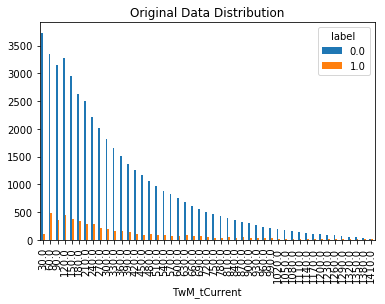

In [6]:
# 1. Prepare
df, X, y = prepare_data(interval)

In [7]:
feature_columns = X.columns
print('There are {} Features'.format(len(feature_columns)))
pprint([x for x in feature_columns])

There are 72 Features
['Spr_generation0',
 'Spr_generation-1',
 'Spr_timeSinceSeed0',
 'Spr_timeSinceSeed-1',
 'Spr_totalNodeInfected',
 'Spr_totalFollowers',
 'Spr_totalFriends',
 'Spr_followersCentrality0',
 'Spr_followersCentrality-1',
 'Spr_friendsCentrality0',
 'Spr_friendsCentrality-1',
 'UsM_deltaDays',
 'UsM_statusesCount',
 'UsM_followersCount',
 'UsM_favouritesCount',
 'UsM_friendsCount',
 'UsM_listedCount',
 'UsM_normalizedUserStatusesCount',
 'UsM_normalizedUserFollowersCount',
 'UsM_normalizedUserFavouritesCount',
 'UsM_normalizedUserListedCount',
 'UsM_normalizedUserFriendsCount',
 'UsM_deltaDays0',
 'UsM_statusesCount0',
 'UsM_followersCount0',
 'UsM_favouritesCount0',
 'UsM_friendsCount0',
 'UsM_listedCount0',
 'UsM_normalizedUserStatusesCount0',
 'UsM_normalizedUserFollowersCount0',
 'UsM_normalizedUserFavouritesCount0',
 'UsM_normalizedUserListedCount0',
 'UsM_normalizedUserFriendsCount0',
 'UsM_deltaDays-1',
 'UsM_statusesCount-1',
 'UsM_followersCount-1',
 'UsM_favo

In [8]:
def train(df, X, y, params, n_folds, num_boost_round):
    # 2. N Fold Split
    # Stratified K-Folds cross-validator
    # Provides train/test indices to split data in train/test sets. 
    # This cross-validation object is a variation of KFold that returns stratified folds. 
    # The folds are made by preserving the percentage of samples for each class.
    skf = StratifiedKFold(n_splits=n_folds, shuffle=True)
    
    corrDataframe = pd.DataFrame()    
    mse = []
    acc = []
    roc = []
    F1 = []
    auc = []
    auc_t = []
    acc_t = []
    fold_count = 0
    t_current = 210
    number_of_features = len(X.columns)

    print("Start cross validation")
    for train, test in skf.split(X, y):
        print("===Processing fold %s===" % fold_count)
        train_fold = df.loc[train]
        test_fold = df.loc[test]

        
#         3. Rebalance (Up-sampling)
        
        method = 'Down-sampling'
        if method == 'Up-sampling':
            diff = sum(train_fold.label == 0) - sum(train_fold.label == 1)
            append_indices = np.random.choice(train_fold[train_fold.label == 1].index, diff, replace=True)
            new_sample = train_fold.loc[append_indices,:]
            train_fold = pd.concat([train_fold, new_sample])
            train_fold = train_fold.reset_index(drop=True)
            print('[Up-sampling] data counts, with uninfected (0): {}, infected (1): {}'.format(
                train_fold['label'].value_counts()[0],
                train_fold['label'].value_counts()[1],
            ))
        else:
            df_majority = train_fold[train_fold.label==0]
            df_minority = train_fold[train_fold.label==1]
 
            # Downsample majority class
            df_majority_downsampled = resample(df_majority, 
                                             replace=False,    # sample without replacement
                                             n_samples=len(df_minority),     # to match minority class
                                             random_state=123) # reproducible results
 
            # Combine minority class with downsampled majority class
            train_fold = pd.concat([df_majority_downsampled, df_minority])
            print('[Down-sampling] data counts, with uninfected (0): {}, infected (1): {}'.format(
                train_fold['label'].value_counts()[0],
                train_fold['label'].value_counts()[1],
            ))
 
        
        
        # 4. Feature Selection
#         corr = train_fold.corr()['label'][train_fold.corr()['label'] < 1].abs()
#         corr = corr.sort_values(ascending=False)
#         corrDataframe = corrDataframe.append(pd.DataFrame(corr.rename('cv{}'.format(fold_count))).T)
#         features = corr.index[range(number_of_features)].values
        features = X.columns
        
        # 5. Training
        # Fit Model
        xgtrain = xgb.DMatrix(train_fold[features].values, train_fold['label'].values)
        xgtest = xgb.DMatrix(test_fold[features].values, test_fold['label'].values)
        evallist = [(xgtrain, 'train'),(xgtest,'eval')]
        
        bst = xgb.train(params, xgtrain, 
                        num_boost_round = num_boost_round, 
                        evals = evallist)

        # 6. Testing
        # Check MSE on test set
        
        test_fold_t = test_fold[test_fold.TwM_tCurrent == t_current]
#             xgtest = xgb.DMatrix(test_fold[features].values)
        xgtest_t = xgb.DMatrix(test_fold_t[features].values)
        pred = bst.predict(xgtest)
        pred_t = bst.predict(xgtest_t)

        mse.append(mean_squared_error(test_fold['label'], pred))
        roc.append(roc_auc_score(test_fold['label'], pred))
        auc_t.append(roc_auc_score(test_fold_t['label'], pred_t))

        acc.append(accuracy_score(test_fold['label'], (pred>0.5).astype(int)))
        acc_t.append(accuracy_score(test_fold_t['label'], (pred_t>0.5).astype(int)))
        F1.append(f1_score(test_fold['label'],(pred>0.5).astype(int)))
        cm = confusion_matrix(test_fold['label'], (pred>0.5).astype(int))
        plot_confusion_matrix(cm, 
                              normalize    = True,
                              target_names = ['Uninfected', 'Infected'],
                              title        = "Confusion Matrix, Normalized")


        fold_count += 1
        # Done with the fold
    print("Finished cross validation")
    print("MSE: {} ".format(DataFrame(mse).mean()))
    print("ACC: {} ".format(DataFrame(acc).mean()))
    print("AUC: {} ".format(DataFrame(roc).mean()))
#     print("F1: {} ".format(DataFrame(F1).mean()))
    print("ACC for t at {}: {} ".format(t_current, DataFrame(acc_t).mean()))
    corrDataframe = corrDataframe.T
    corrDataframe['average corr'] = corrDataframe.mean(numeric_only=True, axis=1)
    print(corrDataframe.sort_values(by=['average corr'], ascending=False).to_string())

    return bst


In [12]:
#xgboost
param = {
    'max_depth': 11,
    # Step size shrinkage used in update to prevents overfitting. 
    # After each boosting step, we can directly get the weights of new features, 
    # and eta shrinks the feature weights to make the boosting process more conservative.
    'eta': 0.1,
    # Minimum loss reduction required to make a further partition on a leaf node of the tree. 
    # The larger gamma is, the more conservative the algorithm will be.
    'gamma':0,
    'min_child_weight':1,
    'silent': 1, # 0 means printing running messages, 1 means silent mode
    'objective': 'binary:logistic',
    'subsample': 0.9
}
param['nthread'] = cpu_count
param['eval_metric'] = ['auc']
num_boost_round = 300

Start cross validation
===Processing fold 0===
[Down-sampling] data counts, with uninfected (0): 2449, infected (1): 2449
[0]	train-auc:0.817624	eval-auc:0.572899
[1]	train-auc:0.865314	eval-auc:0.576369
[2]	train-auc:0.891856	eval-auc:0.584782
[3]	train-auc:0.900895	eval-auc:0.590028
[4]	train-auc:0.910937	eval-auc:0.593818
[5]	train-auc:0.916505	eval-auc:0.596279
[6]	train-auc:0.928233	eval-auc:0.599146
[7]	train-auc:0.932569	eval-auc:0.600186
[8]	train-auc:0.938567	eval-auc:0.602526
[9]	train-auc:0.942458	eval-auc:0.60235
[10]	train-auc:0.944847	eval-auc:0.603159
[11]	train-auc:0.946577	eval-auc:0.603158
[12]	train-auc:0.95143	eval-auc:0.603435
[13]	train-auc:0.953136	eval-auc:0.603695
[14]	train-auc:0.956192	eval-auc:0.602627
[15]	train-auc:0.959019	eval-auc:0.602322
[16]	train-auc:0.960379	eval-auc:0.603267
[17]	train-auc:0.962274	eval-auc:0.603543
[18]	train-auc:0.962602	eval-auc:0.60319
[19]	train-auc:0.965184	eval-auc:0.602831
[20]	train-auc:0.965748	eval-auc:0.603297
[21]	trai

[198]	train-auc:1	eval-auc:0.588876
[199]	train-auc:1	eval-auc:0.588975
[200]	train-auc:1	eval-auc:0.588842
[201]	train-auc:1	eval-auc:0.588917
[202]	train-auc:1	eval-auc:0.588931
[203]	train-auc:1	eval-auc:0.588922
[204]	train-auc:1	eval-auc:0.588791
[205]	train-auc:1	eval-auc:0.588999
[206]	train-auc:1	eval-auc:0.588918
[207]	train-auc:1	eval-auc:0.588998
[208]	train-auc:1	eval-auc:0.58902
[209]	train-auc:1	eval-auc:0.589226
[210]	train-auc:1	eval-auc:0.58925
[211]	train-auc:1	eval-auc:0.589336
[212]	train-auc:1	eval-auc:0.5895
[213]	train-auc:1	eval-auc:0.589456
[214]	train-auc:1	eval-auc:0.589481
[215]	train-auc:1	eval-auc:0.589348
[216]	train-auc:1	eval-auc:0.58936
[217]	train-auc:1	eval-auc:0.589295
[218]	train-auc:1	eval-auc:0.589333
[219]	train-auc:1	eval-auc:0.589613
[220]	train-auc:1	eval-auc:0.589629
[221]	train-auc:1	eval-auc:0.589461
[222]	train-auc:1	eval-auc:0.589548
[223]	train-auc:1	eval-auc:0.589642
[224]	train-auc:1	eval-auc:0.589756
[225]	train-auc:1	eval-auc:0.5895

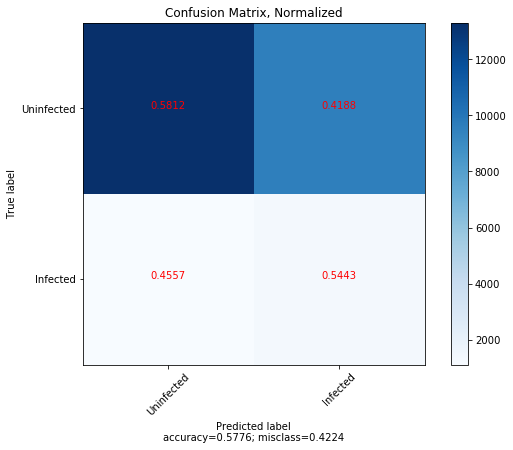

===Processing fold 1===
[Down-sampling] data counts, with uninfected (0): 2449, infected (1): 2449
[0]	train-auc:0.805702	eval-auc:0.573039
[1]	train-auc:0.85735	eval-auc:0.580671
[2]	train-auc:0.877278	eval-auc:0.586877
[3]	train-auc:0.898317	eval-auc:0.587995
[4]	train-auc:0.913849	eval-auc:0.589445
[5]	train-auc:0.921452	eval-auc:0.590593
[6]	train-auc:0.924247	eval-auc:0.590754
[7]	train-auc:0.933433	eval-auc:0.593449
[8]	train-auc:0.936157	eval-auc:0.595446
[9]	train-auc:0.939821	eval-auc:0.595824
[10]	train-auc:0.948003	eval-auc:0.595899
[11]	train-auc:0.949527	eval-auc:0.595607
[12]	train-auc:0.952268	eval-auc:0.597718
[13]	train-auc:0.956017	eval-auc:0.596434
[14]	train-auc:0.95771	eval-auc:0.596741
[15]	train-auc:0.961517	eval-auc:0.596129
[16]	train-auc:0.967541	eval-auc:0.595794
[17]	train-auc:0.969922	eval-auc:0.595873
[18]	train-auc:0.972959	eval-auc:0.593959
[19]	train-auc:0.976334	eval-auc:0.594571
[20]	train-auc:0.976923	eval-auc:0.594802
[21]	train-auc:0.978355	eval-au

[198]	train-auc:1	eval-auc:0.590279
[199]	train-auc:1	eval-auc:0.59026
[200]	train-auc:1	eval-auc:0.590234
[201]	train-auc:1	eval-auc:0.590165
[202]	train-auc:1	eval-auc:0.590133
[203]	train-auc:1	eval-auc:0.590173
[204]	train-auc:1	eval-auc:0.590076
[205]	train-auc:1	eval-auc:0.590116
[206]	train-auc:1	eval-auc:0.59027
[207]	train-auc:1	eval-auc:0.59035
[208]	train-auc:1	eval-auc:0.59031
[209]	train-auc:1	eval-auc:0.590435
[210]	train-auc:1	eval-auc:0.590449
[211]	train-auc:1	eval-auc:0.590623
[212]	train-auc:1	eval-auc:0.590708
[213]	train-auc:1	eval-auc:0.590722
[214]	train-auc:1	eval-auc:0.590795
[215]	train-auc:1	eval-auc:0.590764
[216]	train-auc:1	eval-auc:0.590716
[217]	train-auc:1	eval-auc:0.590832
[218]	train-auc:1	eval-auc:0.590718
[219]	train-auc:1	eval-auc:0.590645
[220]	train-auc:1	eval-auc:0.590757
[221]	train-auc:1	eval-auc:0.590841
[222]	train-auc:1	eval-auc:0.590869
[223]	train-auc:1	eval-auc:0.590698
[224]	train-auc:1	eval-auc:0.590708
[225]	train-auc:1	eval-auc:0.590

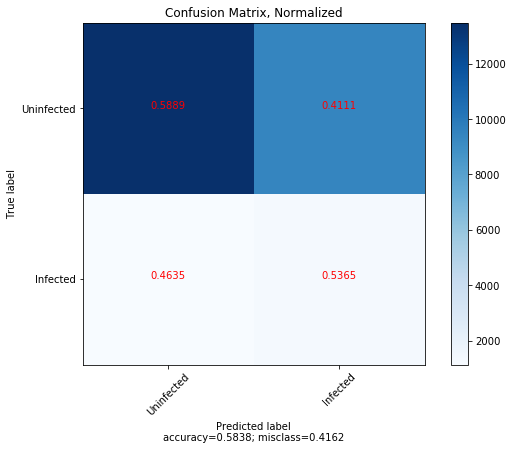

Finished cross validation
MSE: 0    0.301404
dtype: float64 
ACC: 0    0.58074
dtype: float64 
AUC: 0    0.589252
dtype: float64 
ACC for t at 210: 0    0.537035
dtype: float64 
Empty DataFrame
Columns: [average corr]
Index: []


In [13]:
xgb_model = train(df, X, y, param, 2, num_boost_round)

In [ ]:
# load JS visualization code to notebook
shap.initjs()

# train XGBoost model
model = xgb.train(param, xgb.DMatrix(X, label=y), num_boost_round)

# explain the model's predictions using SHAP values
# (same syntax works for LightGBM, CatBoost, and scikit-learn models)
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X)

# visualize the first prediction's explanation
shap.force_plot(explainer.expected_value, shap_values[0,:], X.iloc[0,:])

In [ ]:
with open('xgb_model.dat', 'wb') as file:
    pickle.dump(model, file)

In [ ]:
subsample = list(range(1,len(shap_values),int(len(shap_values)/1000)))

In [ ]:
# visualize the training set predictions
shap.force_plot(explainer.expected_value, shap_values[subsample,:], X.iloc[subsample,:])

In [ ]:
X.columns[0]

In [ ]:
# create a SHAP dependence plot to show the effect of a single feature across the whole dataset
shap.dependence_plot(X.columns[0], shap_values, X)

In [ ]:
# summarize the effects of all the features
shap.summary_plot(shap_values, X)

In [ ]:
shap.summary_plot(shap_values, X, plot_type="bar")

In [ ]:
import matplotlib.pyplot as plt

xgb.plot_tree(xgb_model, num_trees=1)

fig = plt.gcf()
fig.set_size_inches(100, 50)
plt.show()

In [ ]:
xgb.plot_importance(xgb_model)
fig = plt.gcf()
# fig.set_size_inches(50, 100)
plt.show()